In [716]:
# import sys
# sys.path.append("/Users/Wolf1/Python/CheatSheet")

# import clear_variables as clr
# # clr.clear_variables()

def clear_vars(): # same as above, but jupyter's built-in
    %reset -f

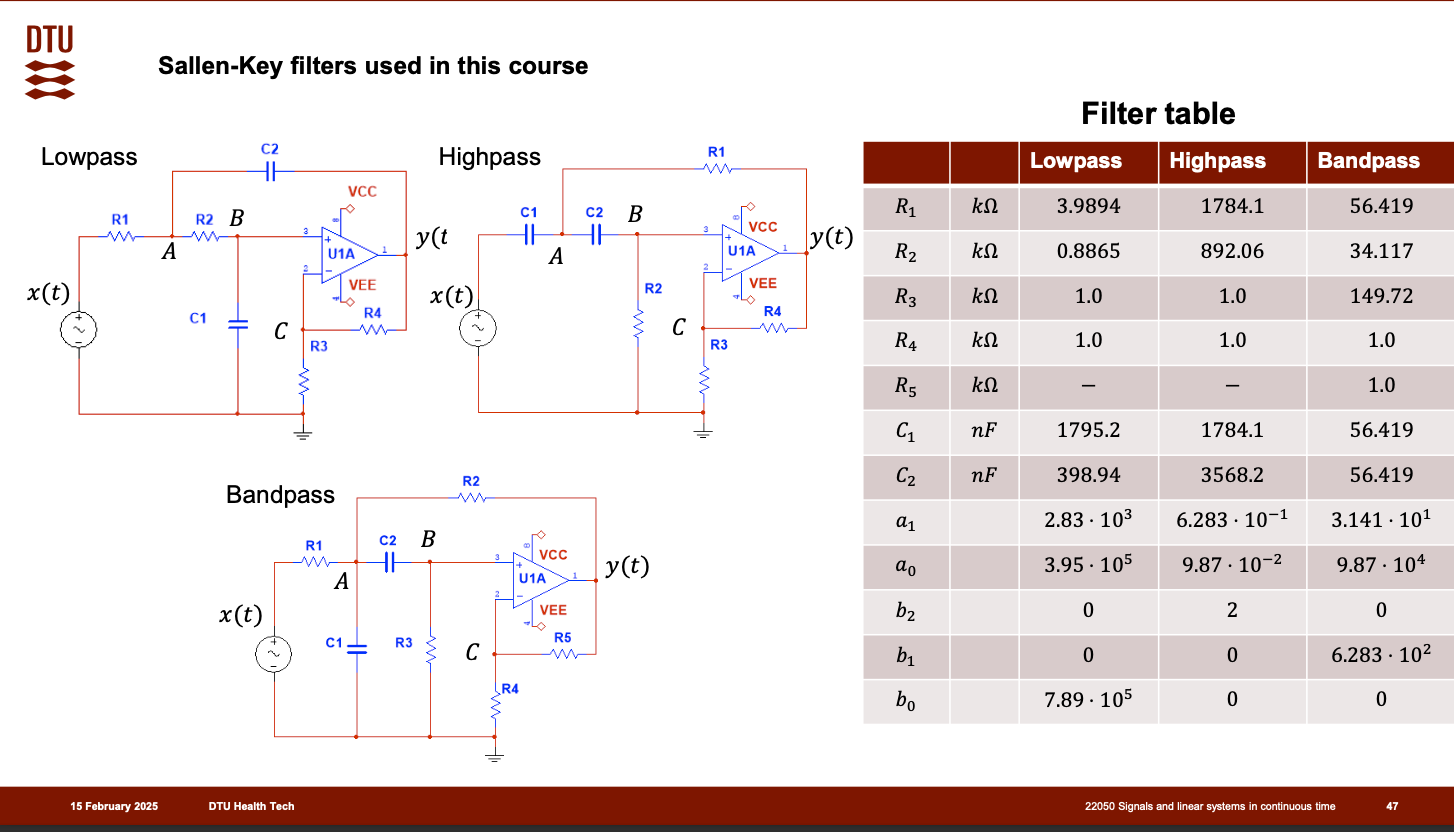

# Filter 7: Lowpass filter - Convolution

In [717]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy import *
init_printing()

R1_val = 3.9894e3
R2_val = 0.8865e3
R3_val = 1e3
R4_val = 1e3
C1_val = 1795.2e-9
C2_val = 398.94e-9

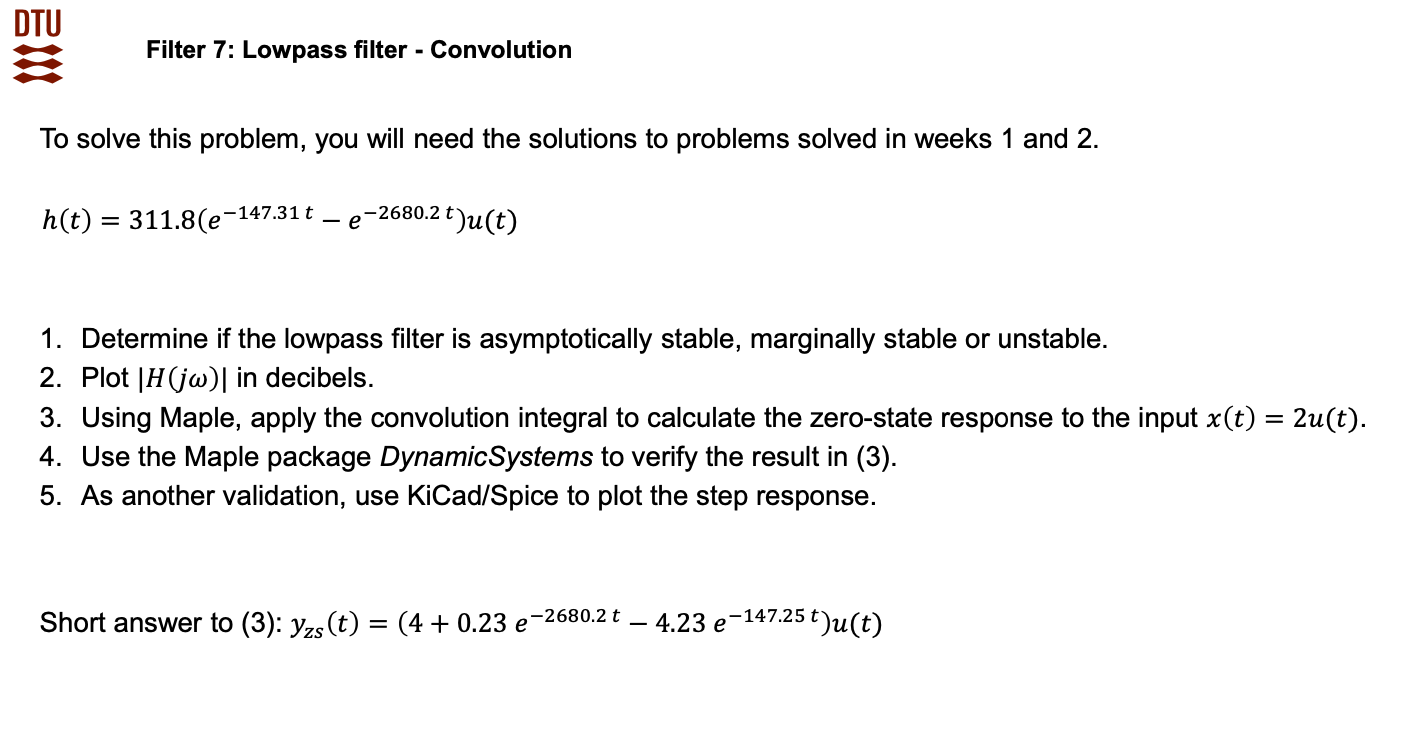

## 1

In [718]:
t, s = symbols('t s')

h_t = 311.8* (exp(-147.31*t) - exp(-2680.2*t)) * Heaviside(t)
h_t = h_t.collect(311.8)
display(h_t)

H_s = laplace_transform(h_t, t, s)[0]
display(H_s)

In [719]:
H_s = H_s.together()              # Force it into a single fraction
num, denom = H_s.as_numer_denom() # Separate numerator and denominator

expr = H_s

# Extract numerator and denominator
num, denom = expr.as_numer_denom()

print("Numerator:", num)
print("Denominator:", denom)
display(num/denom)

Numerator: 789755.102000000
Denominator: (s + 147.31)*(s + 2680.2)


In [720]:
# Extract poles and zeros # technically I only need the poles
zeros = solve(num, s)
display(zeros)

poles = solve(denom, s)
display(poles)

The poles are all in the left-side plane. Hence the filter is asymptotically stable.

## 2

Plot $|𝐻(𝑗𝜔)|$ in decibels.

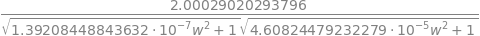

In [721]:
w = symbols('w', real=True)

H_jw = H_s.subs(s, I*w)
H_jw = H_jw.simplify()
display(H_jw)

# Compute magnitude |H(jw)|
H_mag = abs(H_jw)
display(H_mag)

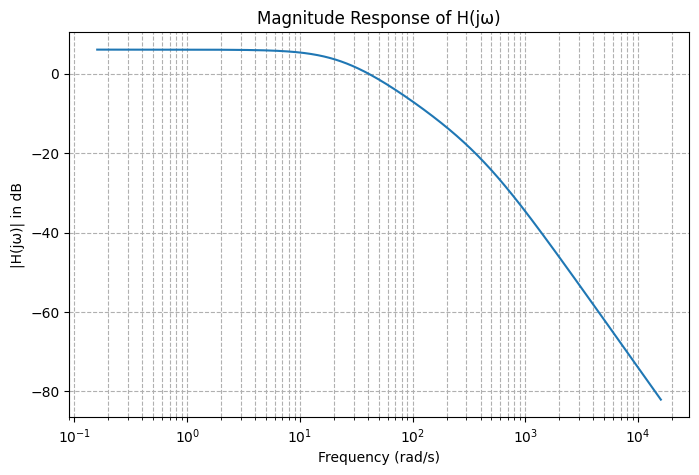

In [722]:
# Convert symbolic expression to numerical function
H_mag_func = lambdify(w, H_mag, 'numpy')  # Creates a function usable with NumPy

# Define frequency range (log scale)
w_vals = np.logspace(0, 5, 1000)  # From 1 rad/s to 100000 rad/s (10^0 to 10^5 on log scale)

f = w_vals / (2 * np.pi)  # Convert rad/s to Hz before plotting

# Compute numerical values of |H(jw)|
H_mag_vals = H_mag_func(w_vals)

# Convert to decibels (dB)
H_dB = 20 * np.log10(H_mag_vals)

# Plot magnitude response in dB
plt.figure(figsize=(8, 5))
plt.semilogx(f, H_dB)  # Logarithmic x-axis   ## plotting as a function of frequency
plt.xlabel('Frequency (rad/s)')
plt.ylabel('|H(jω)| in dB')
plt.title('Magnitude Response of H(jω)')
plt.grid(True, which="both", linestyle="--")

plt.show()

## 3

 apply the convolution integral to calculate the zero-state response to the input $ x(t) = 2u(t)$ 

 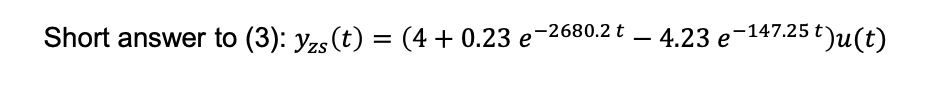

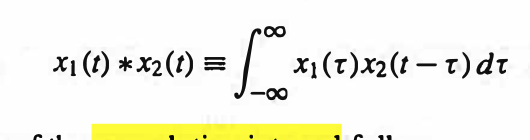

In [723]:
# Define symbols
t, tau = symbols('t tau', real=True, positive=True)

# Define the given functions
h_t = 311.8* (exp(-147.31*t) - exp(-2680.2*t)) * Heaviside(t) # defining again avoids error for some reason
display(h_t)

x_t = 2  * Heaviside(t)
display(x_t)

# Convolution integral
y_t = integrate(x_t * h_t.subs(t, t - tau), (tau, 0, t))
display(y_t)

## 4

Use the Maple package DynamicSystems to verify the result in (3)

In [724]:
R1, R2, R3, R4, C1, C2, K = symbols('R1 R2 R3 R4 C1 C2 K', real=True, positive=True)

K = 1 + R4/R3
a1 = 1/(R2*C2) + 1/(R1*C2) + (1 - K)/(R2*C1)
a0 = 1/(R1*R2*C1*C2)
b0 = K/(R1*R2*C1*C2)

a1 = a1.subs({R1: R1_val, R2: R2_val, R3: R3_val, R4: R4_val, C1: C1_val, C2: C2_val})
a0 = a0.subs({R1: R1_val, R2: R2_val, R3: R3_val, R4: R4_val, C1: C1_val, C2: C2_val})
b0 = b0.subs({R1: R1_val, R2: R2_val, R3: R3_val, R4: R4_val, C1: C1_val, C2: C2_val})
K = K.subs({R1: R1_val, R2: R2_val, R3: R3_val, R4: R4_val, C1: C1_val, C2: C2_val})

a1, a0, b0, K

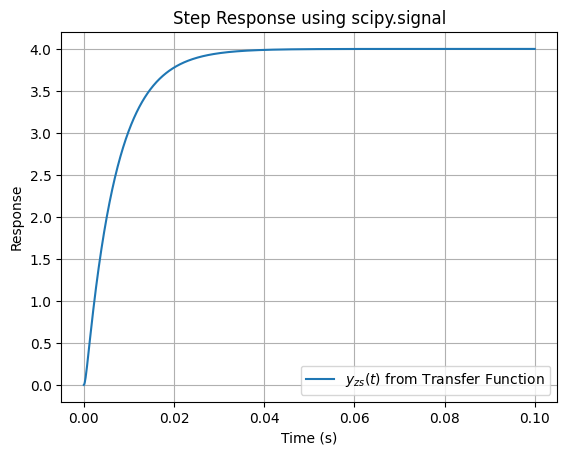

In [725]:
# Define the transfer function H(s) = b0 / (s^2 + a1*s + a0)
num = [b0]  # Numerator coefficients
den = [1, a1, a0]  # Denominator coefficients

# Create an LTI system
system = signal.lti(num, den)

# Generate time vector
t = np.linspace(0, 0.1, 1000)

# Compute step response$
# t_out, y_out = signal.step(system, T=t)
t_out, y_out = signal.lsim(system, U=2*np.ones_like(t), T=t)[0:2]  # valid?
# t_out, y_out = signal.lsim(system, U=2, T=t)[0:2]  # valid?

# Plot the response
plt.plot(t_out, y_out, label=r'$y_{zs}(t)$ from Transfer Function')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('Step Response using scipy.signal')
plt.legend()
plt.grid()
plt.show()

## 5

As another validation, use KiCad/Spice to plot the step response.

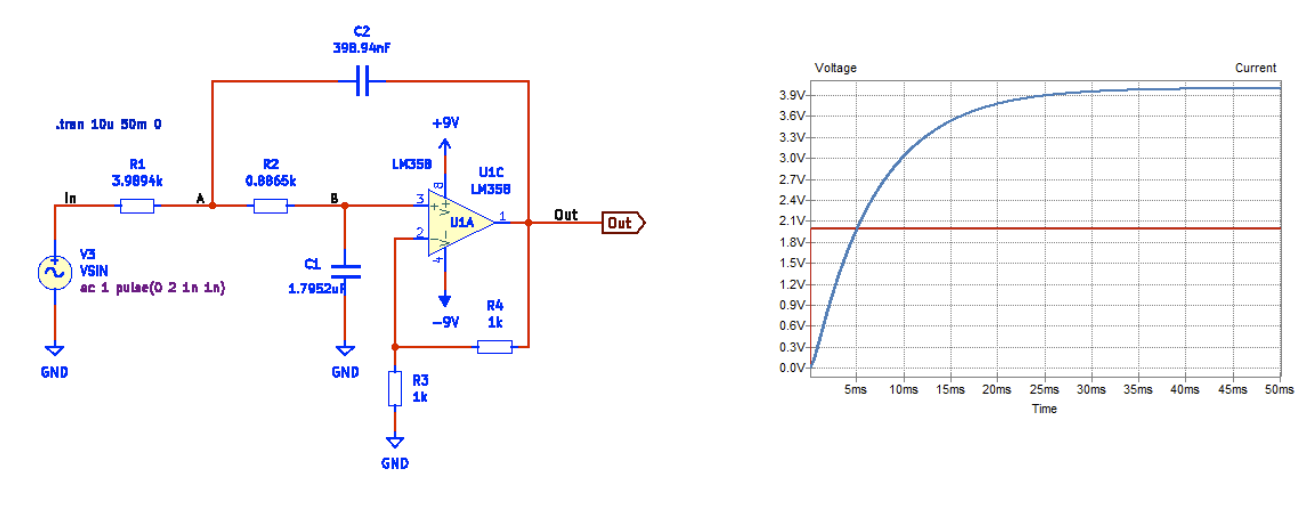

# Filter 8: Highpass filter - Convolution

In [726]:
clear_vars()
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy import *
init_printing()

R1_val = 1784.1e3
R2_val = 892.06e3
R3_val = 1e3
R4_val = 1e3
C1_val = 1784.1e-9
C2_val = 3568.2e-9

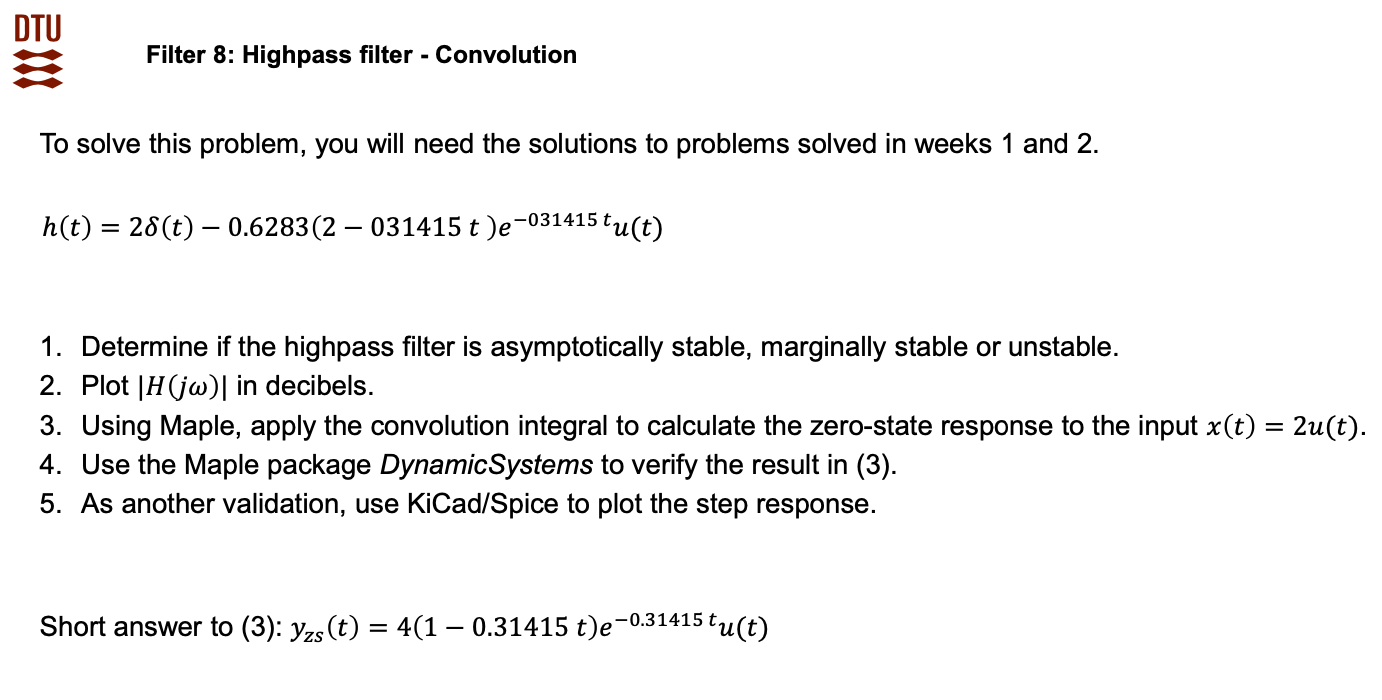

## 1

Determine if the highpass filter is asymptotically stable, marginally stable or unstable.

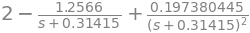

In [727]:
t, s = symbols('t s')

h_t = 2 * DiracDelta(t) - 0.6283 * (2 - 0.31415 * t)*exp(-0.31415*t) * Heaviside(t)
display(h_t)

H_s = laplace_transform(h_t, t, s)[0]
display(H_s)

Numerator: -1.2566*s + 2*(s + 0.31415)**2 - 0.197380445
Denominator: (s + 0.31415)**2


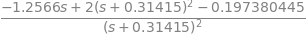

In [728]:
H_s = H_s.together()              # Force it into a single fraction
num, denom = H_s.as_numer_denom() # Separate numerator and denominator

expr = H_s

# Extract numerator and denominator
num, denom = expr.as_numer_denom()

print("Numerator:", num)
print("Denominator:", denom)
display((num/denom))

In [729]:
# Extract poles and zeros # technically I only need the poles
zeros = solve(num, s)
display(zeros)

poles = solve(denom, s)
display(poles)

we see a single pole (with multiplicity of 2) that is negative.

which means that the poles are all in the left-side plane. Hence the filter is asymptotically stable.

## 2

Plot $|H(jw)|$ in decibels.

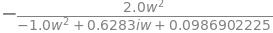

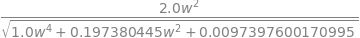

In [730]:
w = symbols('w', real=True)

H_jw = H_s.subs(s, I*w).simplify()
display(H_jw)

# Compute magnitude |H(jw)|
H_mag = abs(H_jw)
display(H_mag)

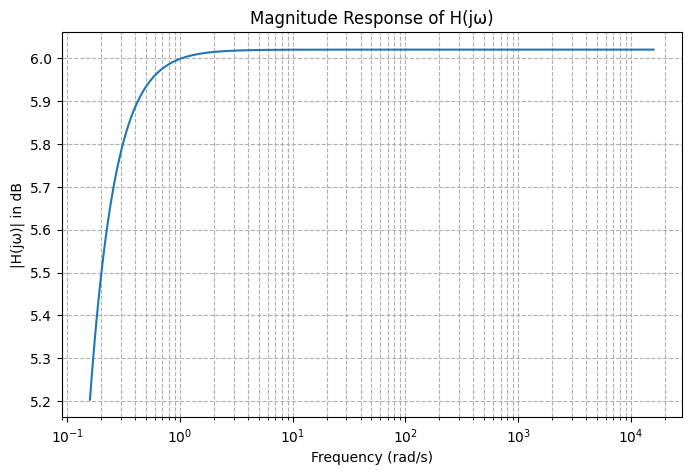

In [731]:
# Convert symbolic expression to numerical function
H_mag_func = lambdify(w, H_mag, 'numpy')  # Creates a function usable with NumPy

# Define frequency range (log scale)
w_vals = np.logspace(0, 5, 1000)  # From 1 rad/s to 100000 rad/s (10^0 to 10^5 on log scale)

f = w_vals / (2 * np.pi)  # Convert rad/s to Hz before plotting

# Compute numerical values of |H(jw)|
H_mag_vals = H_mag_func(w_vals)

# Convert to decibels (dB)
H_dB = 20 * np.log10(H_mag_vals)

# Plot magnitude response in dB
plt.figure(figsize=(8, 5))
plt.semilogx(f, H_dB)  # Logarithmic x-axis   ## plotting as a function of frequency
plt.xlabel('Frequency (rad/s)')
plt.ylabel('|H(jω)| in dB')
plt.title('Magnitude Response of H(jω)')
plt.grid(True, which="both", linestyle="--")

plt.show()

## 3

apply the convolution integral to calculate the zero-state response to the input $x(t) = 2u(t)$

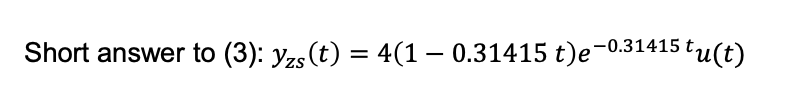

In [732]:
# Define symbols
t, tau = symbols('t tau', real=True, positive=True)

# Define the given functions
h_t = 2 * DiracDelta(t) - 0.6283 * (2 - 0.31415 * t)*exp(-0.31415*t) * Heaviside(t) # defining again avoids error for some reason
display(h_t)

x_t = 2  * Heaviside(t)
display(x_t)

# Convolution integral
y_t = integrate(x_t * h_t.subs(t, t - tau), (tau, 0, t))
display( collect(y_t.factor(), 4))

## 4

verify the result in (3).

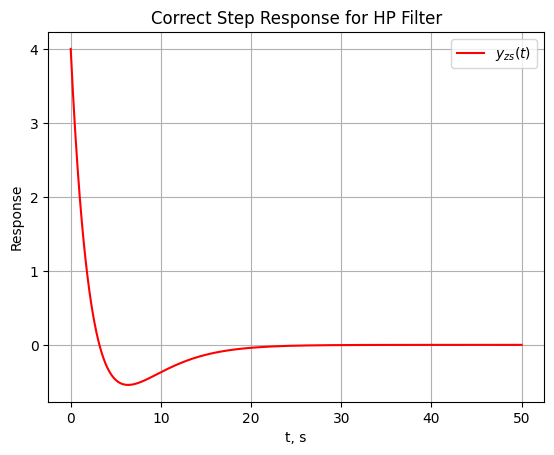

In [733]:
# Define symbolic coefficients with correct formulas
R1, R2, R3, R4, C1, C2 = symbols('R1 R2 R3 R4 C1 C2', positive=True, real=True)

# coefficients of an HP filter
K = 1 + R4 / R3
a1 = 1/(R2*C2) + 1/(R2*C1) + (1 - K)/(R1*C1)
a0 = 1/(R1 * R2 * C1 * C2)
b2 = K

# Substitute your component values
subs = {
    R1: 1784.1e3,
    R2: 892.06e3,
    R3: 1e3,
    R4: 1e3,
    C1: 1784.1e-9,
    C2: 3568.2e-9
}

a1_val = float(a1.subs(subs)) # scipy.signal.lsim() doesn't like sympy expressions so we need to convert to python float
a0_val = float(a0.subs(subs))
b2_val = float(b2.subs(subs))  # this is K
K_val =  float(K.subs(subs))

display((a1_val, a0_val, b2_val, K_val))

# Define transfer function
num = [2*b2_val, 0, 0]
den = [1, a1_val, a0_val]

# Simulate using lsim
system = signal.lti(num, den)
t = np.linspace(0, 50, 1000)
u = np.ones_like(t)
t_out, y_out, _ = signal.lsim(system, U=u, T=t)

# Plot
plt.plot(t_out, y_out, color='red', label=r'$y_{zs}(t)$')
plt.xlabel('t, s')
plt.ylabel('Response')
plt.title('Correct Step Response for HP Filter')
plt.grid()
plt.legend()
plt.show()


## 5

validate in Kicad

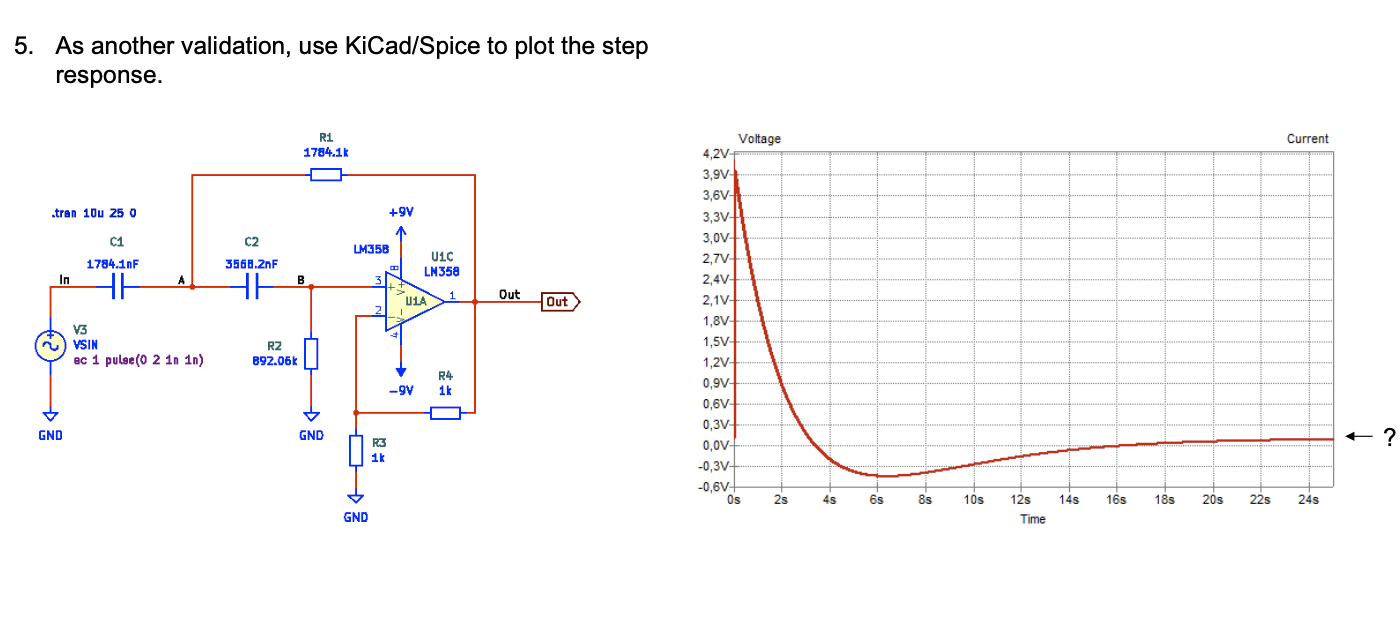

# Filter 9: Bandpass filter - Convolution

In [ ]:
def clear_vars(): 
    %reset -f
clear_vars()
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy import *
init_printing()

R1_val = 56.419e3
R2_val = 34.117e3
R3_val = 149.72e3
R4_val = 1e3
R5_val = 1e3
C1_val = 56.419e-9
C2_val = 56.419e-9

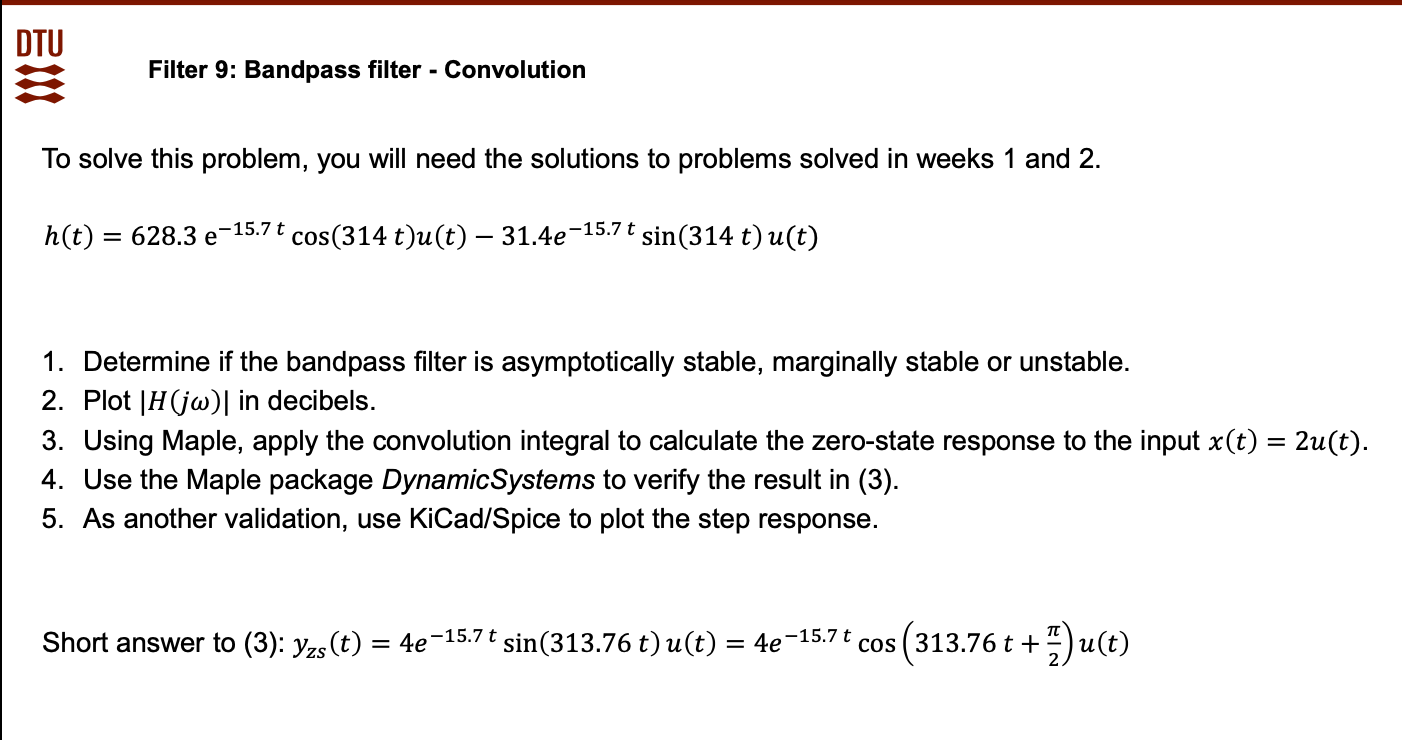

## 1


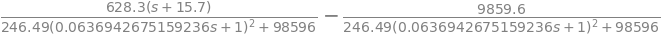

In [735]:
t, s = symbols('t s')

h_t = 628.3 *exp(-15.7*t) * cos(314*t) * Heaviside(t) - 31.4*exp(-15.7*t) * sin(314*t) * Heaviside(t)
display(h_t)

H_s = laplace_transform(h_t, t, s)[0]
display(H_s)

Numerator: 628.3*s + 4.70999999999913
Denominator: 246.49*(0.0636942675159236*s + 1)**2 + 98596


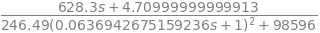

In [736]:
H_s = H_s.together()              # Force it into a single fraction
num, denom = H_s.as_numer_denom() # Separate numerator and denominator

expr = H_s

# Extract numerator and denominator
num, denom = expr.as_numer_denom()

print("Numerator:", num)
print("Denominator:", denom)
display(num/denom)

In [737]:
# Extract poles and zeros # technically I only need the poles
zeros = solve(num, s)
display(zeros)

poles = solve(denom, s)
display(poles)

what matters for asymptotic stability is the **REAL** part of each pole.

so....

The poles are all in the left-side plane. Hence the filter is asymptotically stable.

## 2

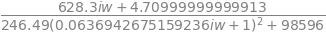

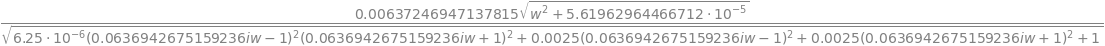

In [738]:
w = symbols('w', real=True)

H_jw = H_s.subs(s, I*w)
H_jw = H_jw.simplify()
display(H_jw)

# Compute magnitude |H(jw)|
H_mag = abs(H_jw)
display(H_mag)

/Users/Wolf1/Python/4th_sem/.venv_4sem/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Wolf1/Python/4th_sem/.venv_4sem/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


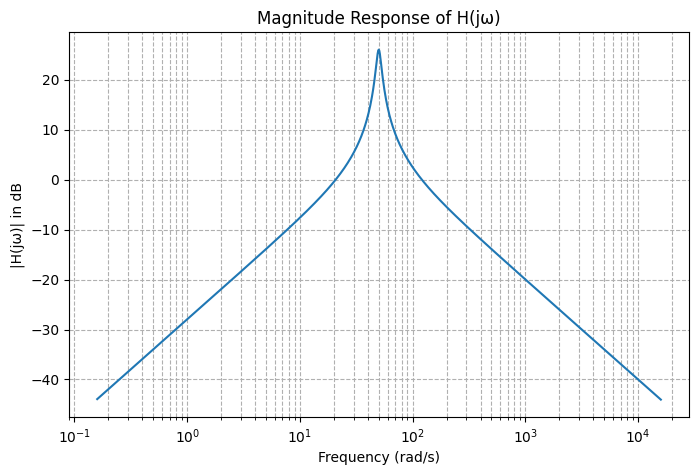

In [739]:
# Convert symbolic expression to numerical function
H_mag_func = lambdify(w, H_mag, 'numpy')  # Creates a function usable with NumPy

# Define frequency range (log scale)
w_vals = np.logspace(0, 5, 1000)  # From 1 rad/s to 100000 rad/s (10^0 to 10^5 on log scale)

f = w_vals / (2 * np.pi)  # Convert rad/s to Hz before plotting

# Compute numerical values of |H(jw)|
H_mag_vals = H_mag_func(w_vals)

# Convert to decibels (dB)
H_dB = 20 * np.log10(H_mag_vals)

# Plot magnitude response in dB
plt.figure(figsize=(8, 5))
plt.semilogx(f, H_dB)  # Logarithmic x-axis   ## plotting as a function of frequency
plt.xlabel('Frequency (rad/s)')
plt.ylabel('|H(jω)| in dB')
plt.title('Magnitude Response of H(jω)')
plt.grid(True, which="both", linestyle="--")

plt.show()

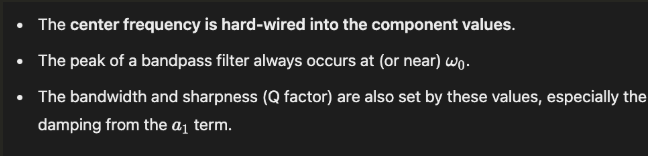

In [740]:
center_freq = 10**1 * 5 # count number of lines starting with 10^1 and multiply by the number of lines (5)
center_freq

## 3

apply the convolution integral to calculate the zero-state response to the input $x(t) = 2u(t)$

In [741]:
# Define symbols
t, tau = symbols('t tau', real=True, positive=True)

# Define the given functions
h_t = 628.3 *exp(-15.7*t) * cos(314*t) * Heaviside(t) - 31.4*exp(-15.7*t) * sin(314*t) * Heaviside(t) # defining again avoids error for some reason
display(h_t)

x_t = 2  * Heaviside(t)
display(x_t)

# Convolution integral
y_t = integrate(x_t * h_t.subs(t, t - tau), (tau, 0, t))
display(y_t)
# display( collect(y_t.factor(), 4))

y_clean = y_t.rewrite(cos).simplify()
display(y_clean)

In [742]:
# Assuming y_clean is of the form: A*sin(ωt) + B*cos(ωt), extract coefficients
y_expr = y_clean.expand()
display(y_expr)

# Extract coefficients manually
A_term = y_expr.coeff(sin(314*t))
B_term = y_expr.coeff(cos(314*t))
display(A_term, B_term)

# Compute magnitude and phase
R = simplify(sqrt(A_term**2 + B_term**2))
phi = simplify(atan2(A_term, B_term))
display(R, phi)

# Construct result as single cosine with phase shift
y_final = simplify(R * exp(-15.7*t) * cos(314*t - phi))
display(y_final)

the exponent of e (-31.4*t) has been doubled. (divide by 2)

In [743]:
-31.4*t / 2

## 4

verify results from (3)

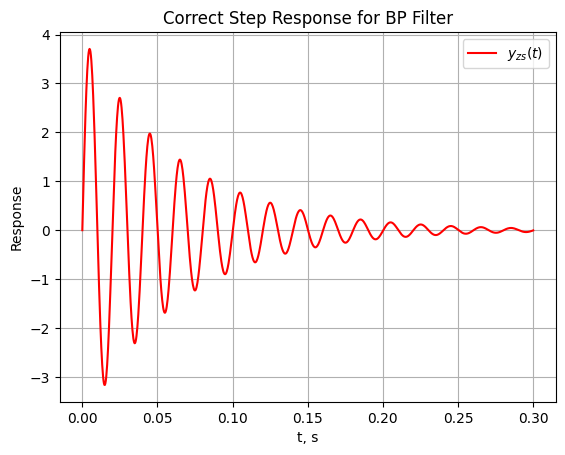

In [744]:
# Define symbolic coefficients with correct formulas
R1, R2, R3, R4, R5, C1, C2 = symbols('R1 R2 R3 R4 R5 C1 C2', positive=True, real=True)

# coefficients of an HP filter
K = 1 + R5 / R4
a1 = 1/(R1*C1) + 1/(R3*C2) + 1/(R3*C1) + (1-K)/(R2*C1)
a0 = (1/R1 + 1/R2) * (1/(R3*C1*C2))
b1 = 1/(R1*C1) * K

# Substitute your component values
subs = {
    R1: 56.419e3,
    R2: 34.117e3,
    R3: 149.72e3,
    R4: 1e3,
    R5: 1e3,
    C1: 56.419e-9,
    C2: 56.419e-9
}

a1_val = float(a1.subs(subs)) # scipy.signal.lsim() doesn't like sympy expressions so we need to convert to python float
a0_val = float(a0.subs(subs))
b1_val = float(b1.subs(subs))  # this is K
K_val =  float(K.subs(subs))

display((a1_val, a0_val, b1_val, K_val))

# Define transfer function
num = [0, b1_val, 0]
den = [1, a1_val, a0_val]

# Simulate using lsim
system = signal.lti(num, den)
t = np.linspace(0, 0.3, 1000)
u = 2 * np.ones_like(t) # amplitude of 2
t_out, y_out, _ = signal.lsim(system, U=u, T=t)

# Plot
plt.plot(t_out, y_out, color='red', label=r'$y_{zs}(t)$')
plt.xlabel('t, s')
plt.ylabel('Response')
plt.title('Correct Step Response for BP Filter')
plt.grid()
plt.legend()
plt.show()

In [745]:
f = symbols('f', real=True)

timePeriod = 0.02 # counted from the plot (with   t = np.linspace(0, 0.1, 1000) )
func = Eq(1/f, timePeriod)
solve(func, f)    # the center frequency is 50 Hz confirming the previous calculation

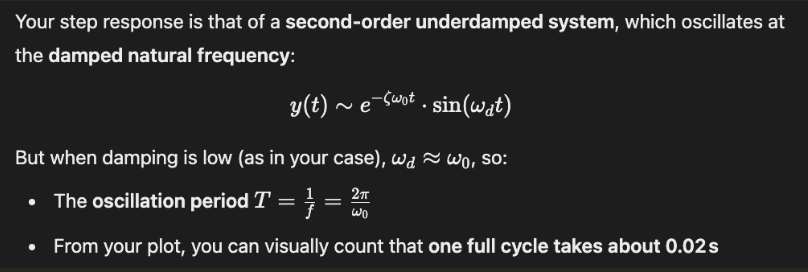

## 5

verify in kicad

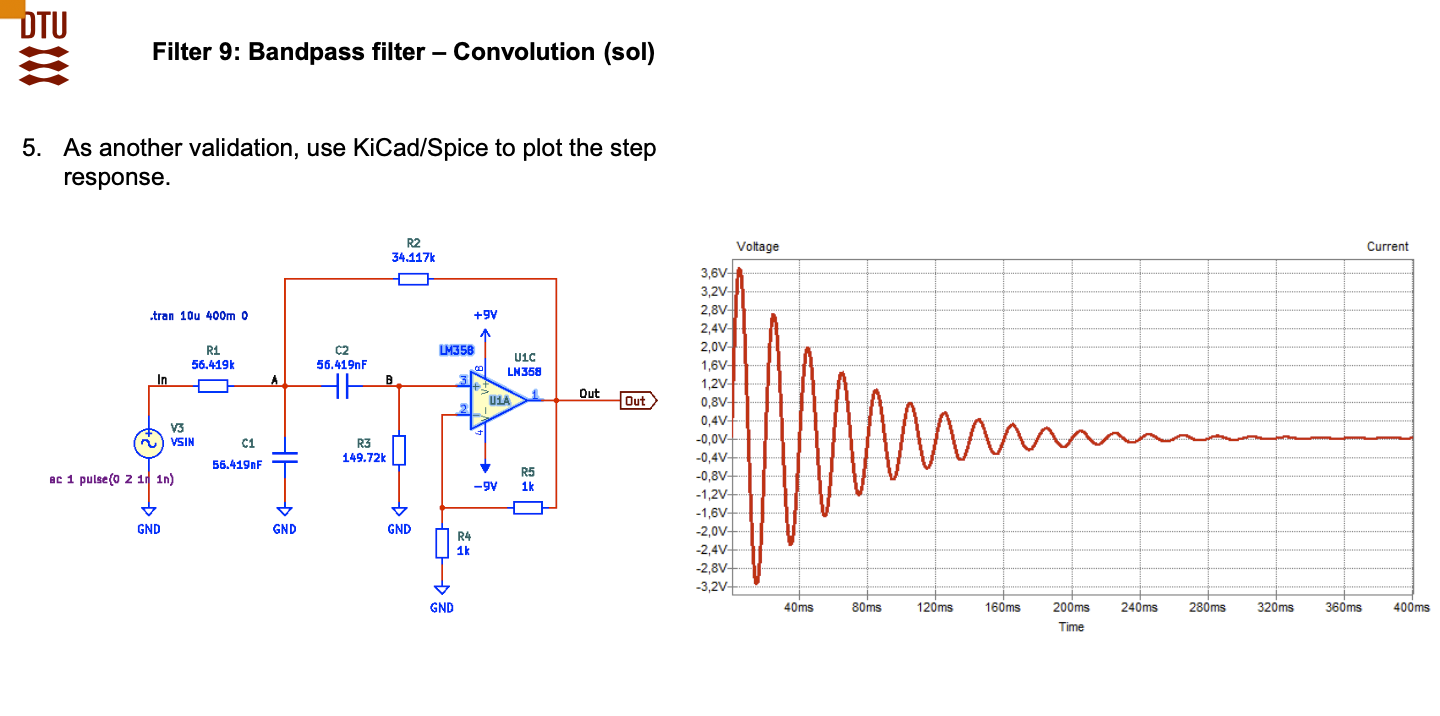